In [4]:
import sys
sys.path.append("..") 
import numpy as np
import matplotlib.pyplot as plt
from src.sgd.sgd import SGD
from src.plotting.plot_utils import plot_phase_transition
from src.models.regression_model import RegressionModel
from src.data.generate_synthetic_data import transform_to_polynomial
from sklearn.model_selection import train_test_split

In [5]:
np.random.seed(0)
d_values = [2,3,4,5]
l_values = [2,3]
s = 0.0
noise = 0.0
max_n = 5000  
stepsize_methods = ["fixed", "halving", "diminishing"]

results = {}


=== Running for d=2, l=2 ===
d=2, l=2, n=6, fixed: Train Loss=0.0336, Test Loss=1.6899
d=2, l=2, n=6, halving: Train Loss=0.0322, Test Loss=1.6557
d=2, l=2, n=6, diminishing: Train Loss=0.0313, Test Loss=1.6049
d=2, l=2, n=8, fixed: Train Loss=0.1198, Test Loss=0.4162
d=2, l=2, n=8, halving: Train Loss=0.1119, Test Loss=0.3944
d=2, l=2, n=8, diminishing: Train Loss=0.1136, Test Loss=0.4017
d=2, l=2, n=12, fixed: Train Loss=0.0239, Test Loss=0.1509
d=2, l=2, n=12, halving: Train Loss=0.0206, Test Loss=0.1373
d=2, l=2, n=12, diminishing: Train Loss=0.0228, Test Loss=0.1463
d=2, l=2, n=18, fixed: Train Loss=0.0003, Test Loss=0.0672
d=2, l=2, n=18, halving: Train Loss=0.0003, Test Loss=0.0694
d=2, l=2, n=18, diminishing: Train Loss=0.0003, Test Loss=0.0701
d=2, l=2, n=25, fixed: Train Loss=0.0000, Test Loss=0.0000
d=2, l=2, n=25, halving: Train Loss=0.0000, Test Loss=0.0000
d=2, l=2, n=25, diminishing: Train Loss=0.0002, Test Loss=0.0010
d=2, l=2, n=37, fixed: Train Loss=0.0000, Test Loss

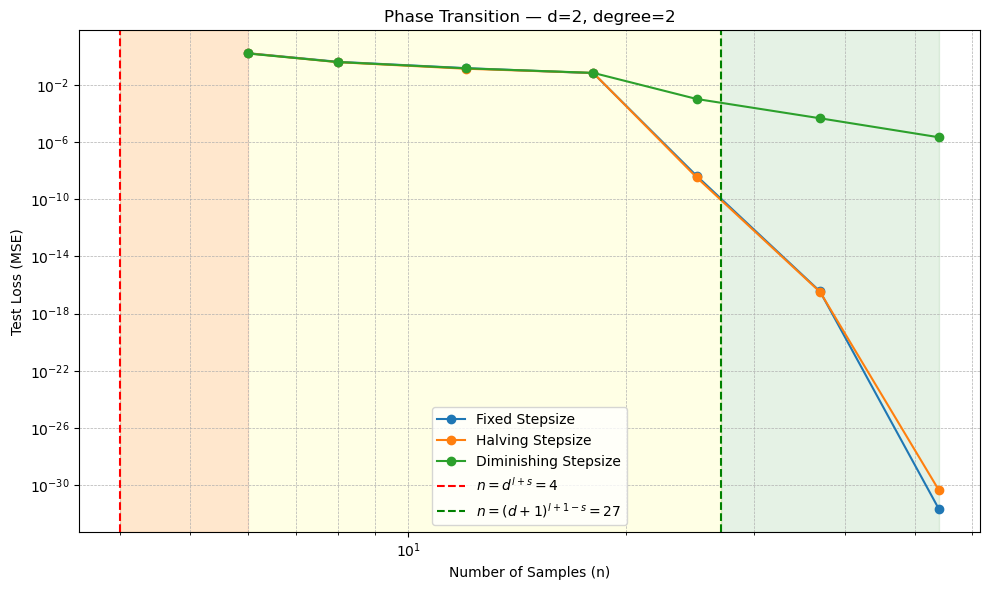

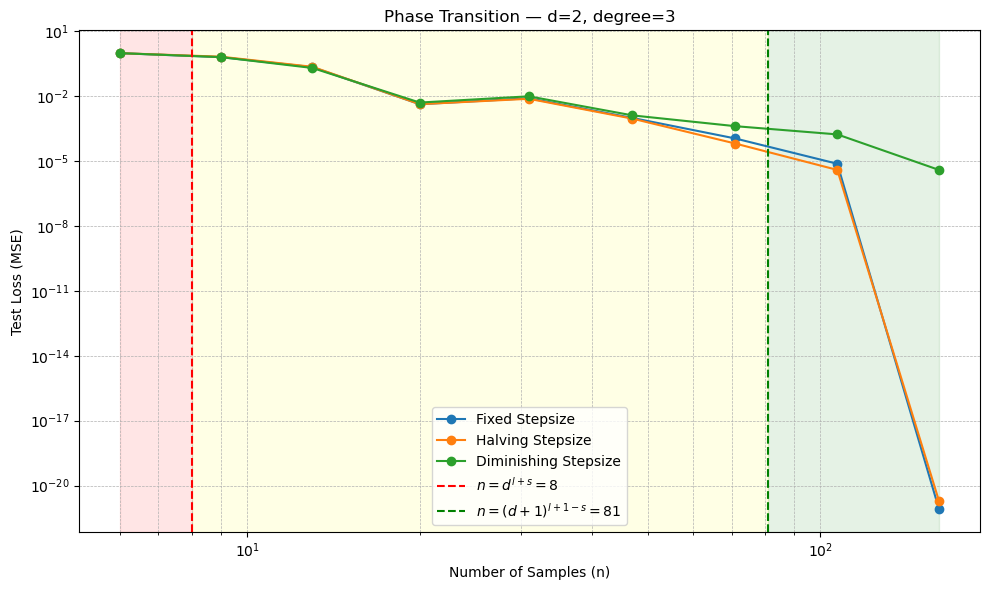

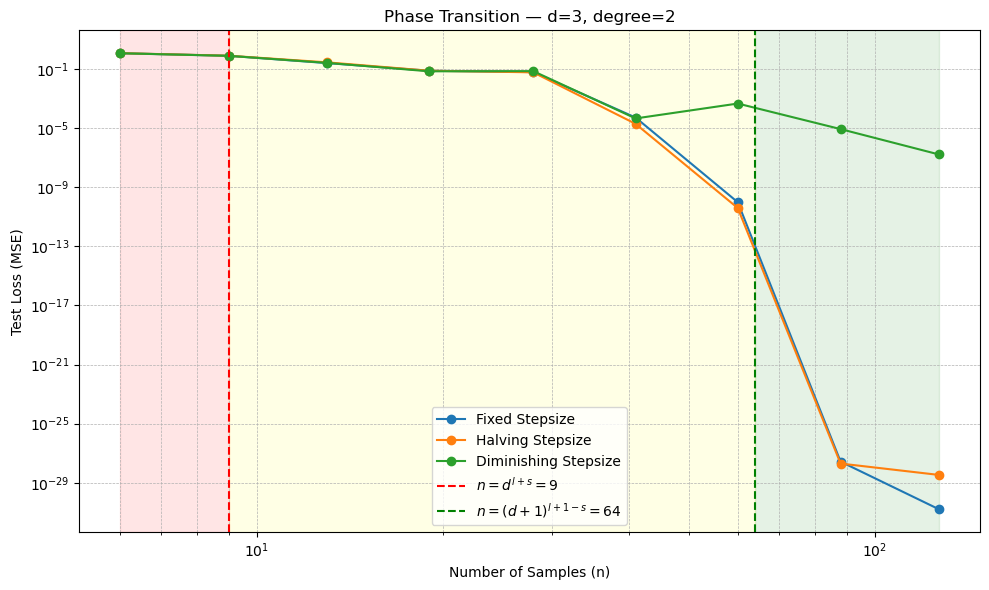

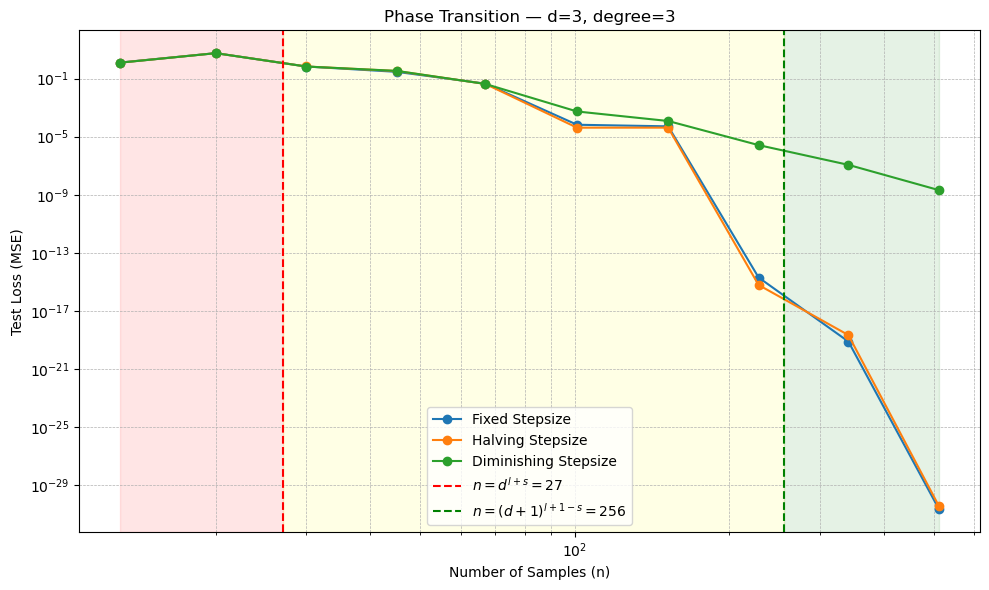

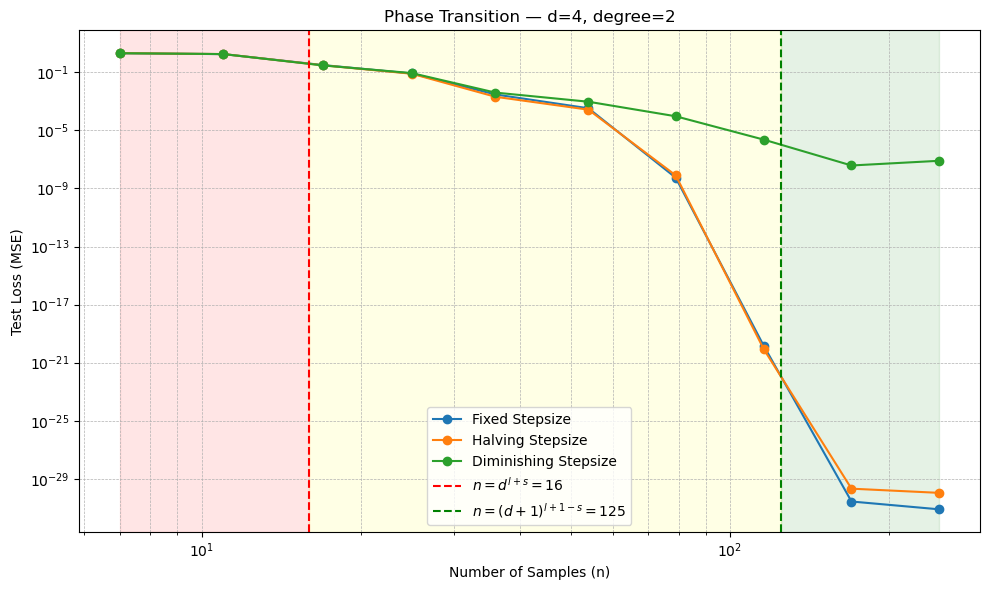

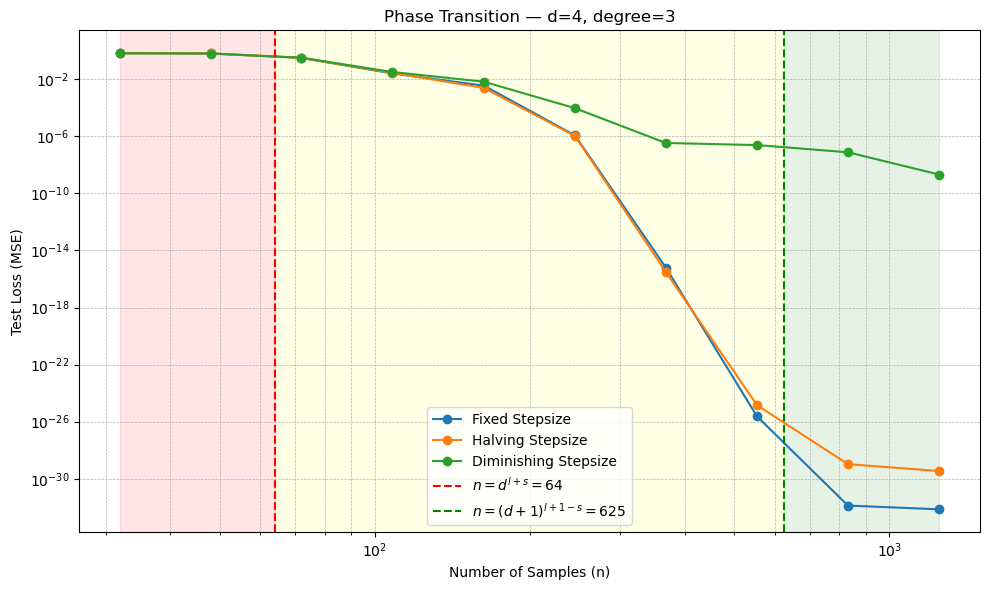

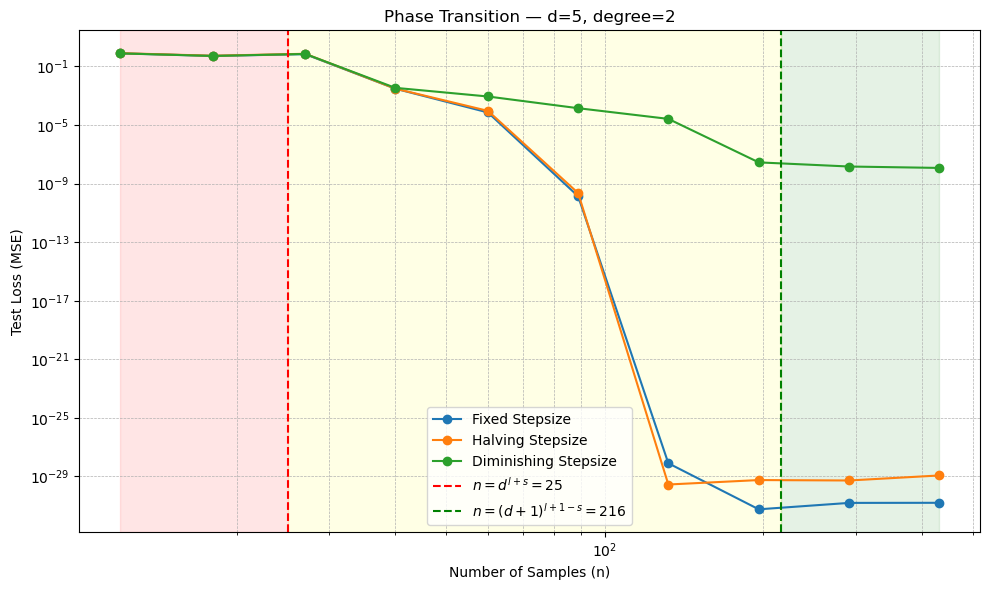

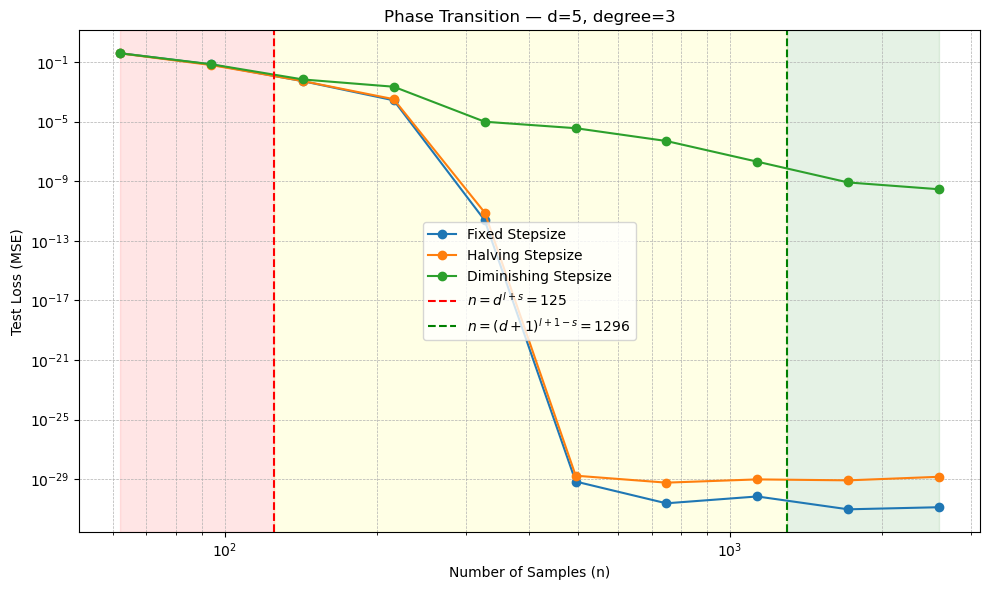

In [6]:
for d in d_values:
    for l in l_values:
        print(f"\n=== Running for d={d}, l={l} ===")

        lower_threshold_n = int((d)**(l+s))
        upper_threshold_n = int((d + 1)**(l + 1 + s))
        ns = np.unique(np.logspace(np.log10(lower_threshold_n / 2), np.log10(upper_threshold_n * 2), num=10, dtype=int))
        ns = [n for n in ns if n >= 5]

        X_raw = np.random.normal(0, 1, size=(max_n, d))
        X_true_poly = transform_to_polynomial(X_raw, degree=l, normalize=True)

        true_A = 0.001 * np.arange(1, X_true_poly.shape[1] + 1)
        true_b = 1.0
        y_full = X_true_poly @ true_A + true_b + np.random.normal(0, noise, size=max_n)

        results[(d, l)] = {method: {"train": [], "test": [], "ns": ns, "weights": []} for method in stepsize_methods}

        for n in ns:
            X_n = X_raw[:n]
            y_n = y_full[:n]
            X_poly_n = transform_to_polynomial(X_n, degree=l, normalize=True)

            X_train, X_test, y_train, y_test = train_test_split(X_poly_n, y_n, test_size=0.3)

            for method in stepsize_methods:
                model = RegressionModel(X_train, y_train)
                sgd = SGD(model=model, num_epochs=n, batch_size=1, noise=noise, stepsize_type=method)
                w, obj, grad, dist = sgd.optimize()

                results[(d, l)][method]["weights"].append(w)
                results[(d, l)][method]["train"].append(obj[-1])
                test_pred = X_test @ w[1:] + w[0]
                test_loss = np.mean((test_pred - y_test) ** 2)
                results[(d, l)][method]["test"].append(test_loss)

                print(f"d={d}, l={l}, n={n}, {method}: Train Loss={obj[-1]:.4f}, Test Loss={test_loss:.4f}")
        plot_phase_transition(
            results=results,
            d=d,
            l=l,
            s=s,
            stepsize_methods=stepsize_methods,
            save_dir="plots")

In [7]:
# Comparison of weights
d = 3
l_values = [2, 3]
ns2 = [6, 10, 20, 50, 80, 100, 150, 200, 300, 500]

X_raw = np.random.normal(0, 1, size=(max_n, d))
X_true_poly = transform_to_polynomial(X_raw, degree=3, normalize=True)
true_A = 0.001 * np.arange(1, X_true_poly.shape[1] + 1)
true_b = 1.0
y_full = X_true_poly @ true_A + true_b + np.random.normal(0, noise, size=max_n)

results2 = {}
for l in l_values:
    print(f"\n=== Running for d={d}, l={l} ===")
    results2[(d, l)] = {method: {"train": [], "test": [], "ns": ns2, "weights": []} for method in stepsize_methods}
    
    for n in ns2:
        X_n = X_raw[:n]
        y_n = y_full[:n]
        X_poly_n = transform_to_polynomial(X_n, degree=l, normalize=True)

        X_train, X_test, y_train, y_test = train_test_split(X_poly_n, y_n, test_size=0.3)

        for method in stepsize_methods:
            model = RegressionModel(X_train, y_train)
            sgd = SGD(model=model, num_epochs=n, batch_size=1, noise=noise, stepsize_type=method)
            w, obj, grad, dist = sgd.optimize()

            results2[(d, l)][method]["weights"].append(w)
            results2[(d, l)][method]["train"].append(obj[-1])
            test_pred = X_test @ w[1:] + w[0]
            test_loss = np.mean((test_pred - y_test) ** 2)
            results2[(d, l)][method]["test"].append(test_loss)

            


=== Running for d=3, l=2 ===

=== Running for d=3, l=3 ===


In [8]:
def compare_deg3_to_deg2_weights(d, results, method="fixed", delta=1e-3):
    ns_deg3 = results[(d, 3)][method]["ns"]
    ns_deg2 = results[(d, 2)][method]["ns"]
    weights_deg3 = results[(d, 3)][method]["weights"]
    weights_deg2 = results[(d, 2)][method]["weights"]

    print(f"Comparison of degree 3 to degree 2 weights (d = {d}, method = '{method}') \n")
    for n in ns2:
        idx_3 = ns_deg3.index(n)
        idx_2 = ns_deg2.index(n)

        w3 = weights_deg3[idx_3]
        w2 = weights_deg2[idx_2]

        w2_main = w2[1:]
        w3_main = w3[1:len(w2_main)+1] 

        diff = np.abs(w3_main - w2_main)
        significant_diff = diff[diff > delta]
        sum_diff = np.sum(significant_diff)

        print(f"n = {n} | Significant diff terms: {len(significant_diff)} | Sum = {sum_diff:.6f} | Difference by coefficient = {sum_diff/(len(significant_diff)):.6f}")

In [9]:
compare_deg3_to_deg2_weights(d=3, results=results)


Comparison of degree 3 to degree 2 weights (d = 3, method = 'fixed') 



ValueError: 6 is not in list